In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn-whitegrid')
import matplotlib.pyplot as plt
import proplot as pplt

In [2]:
import numpy as np
import pandas as me
import datetime as dt

#### Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# create session from Python to the db
session = Session(engine)

#### Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# `calc_temps` functions will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# using 'calc_temps` function to calculate the tmin, tavg, and tmax 
# for a year in the data set, starting with 8/1/2017 as trip date
tmin,tavg,tmax = calc_temps('2017-08-01', '2017-08-07')[0]
print(tmin,tavg,tmax)

72.0 79.25 83.0


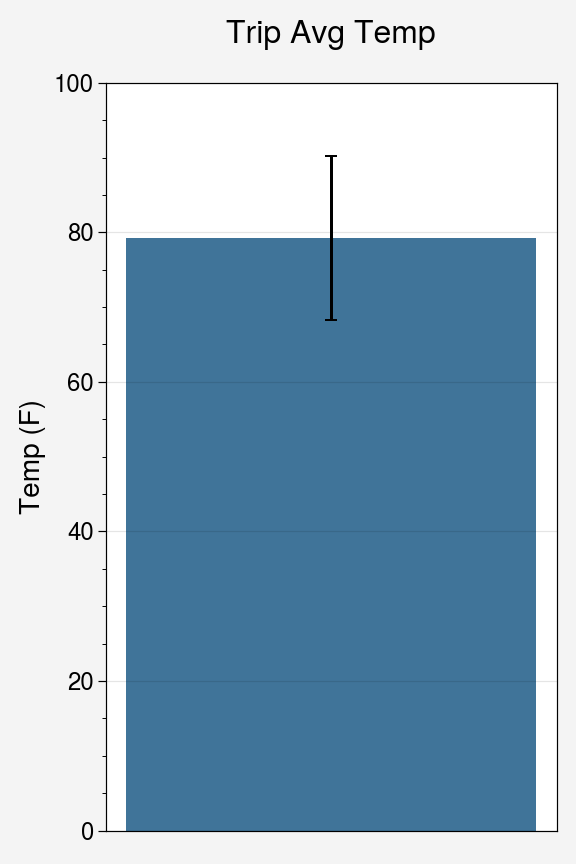

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig = plt.figure(figsize=(4,6))

plt.subplot()
plt.bar(x=0, height=tavg, yerr=(tmax-tmin), color='xkcd:prussian blue', alpha=.75)
plt.xticks([])
plt.ylim(0,100)
plt.yticks(fontsize=12)
plt.ylabel("Temp (F)", fontsize=14)
plt.title('Trip Avg Temp', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('Images/trip_avg_temp.png')
plt.show()

#### Daily Rainfall Average

In [12]:
# calculating the total amount of rainfall per weather station for trip dates using the previous year's matching dates.
# sorted in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [station.name, station.latitude, station.longitude, station.elevation]
precip_data = session.query(*sel).filter(measurement.station == station.station )\
                       .filter(measurement.date.between('2016-08-07','2017-08-07'))\
                       .group_by(measurement.station)\
                       .order_by(measurement.prcp.desc()).all()

precip_df = me.DataFrame(precip_data, columns=['station','prcp','lat','lng'])
precip_df

,station,prcp,lat,lng
0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
6,"PEARL CITY, HI US",21.39340,-157.97510,11.9


#### Daily Temperature Normals

In [13]:
# use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = dt.datetime.strptime('2017-08-01', '%Y-%m-%d').date()
trip_end_date = dt.datetime.strptime('2017-08-07', '%Y-%m-%d').date()

# Use the start and end date to create a range of dates
date_range = (trip_start_date + dt.timedelta(days=i) for i in range(0, 1 + (trip_end_date - trip_start_date).days))

# Strip off the year and save a list of strings in the format %m-%d
dates_list = []
for date in date_range:
    dates_list.append(date.strftime('%Y-%m-%d')) 

trip_dates = []
for day in dates_list:
    trip_dates.append(day.split('-')[1] + '-' + day.split('-')[2])

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
daily_normals_list = []
for t in trip_dates:
    daily_normals_list.append(daily_normals(t))

# split min, avg, and max temps to prepare for dictionary
min_temp = []
avg_temp = []
max_temp = []

for normal in daily_normals_list:
    min_temp.append(normal[0][0])
    avg_temp.append(normal[0][1])
    max_temp.append(normal[0][2])

# create dictionary for easier transfer to dataframe
temperature_dict = {'date': trip_dates,
                    'minimum temp.': min_temp,
                    'average temp.': avg_temp,
                    'maximum temp.': max_temp}

In [15]:
# load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = me.DataFrame(temperature_dict).set_index('date')
trip_normals_df

,minimum temp.,average temp.,maximum temp.
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


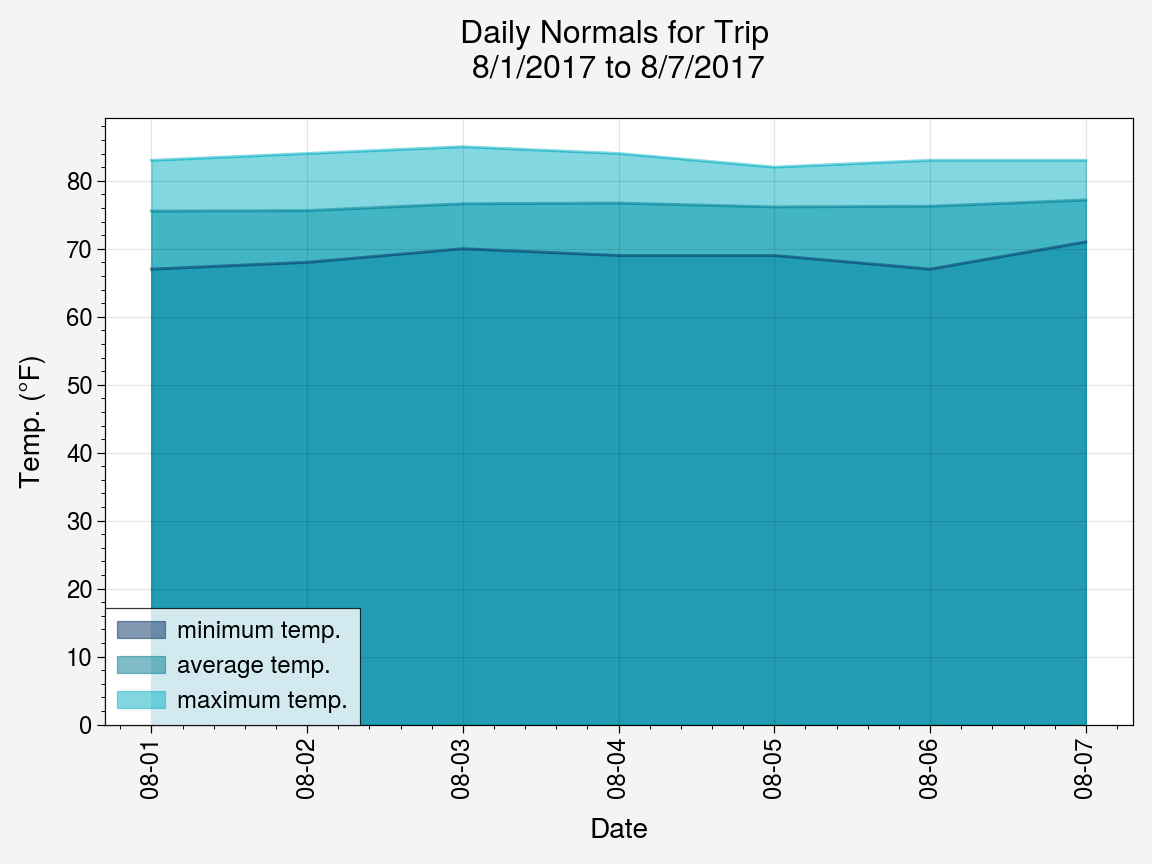

In [21]:
# plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot.area(stacked=False, rot=90, figsize=(8,6), color=['xkcd:marine','xkcd:ocean','xkcd:turquoise blue'], alpha=0.5)
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.ylabel('Temp. (°F)', fontsize=14, labelpad=10)
plt.yticks(fontsize=12)
plt.legend(loc='best', prop={'size': 12})
plt.title(f'Daily Normals for Trip \n8/1/2017 to 8/7/2017', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('Images/trip_dailies.png')
plt.show()

## Close Session

In [17]:
session.close()